In [4]:
import numpy as np 
import matplotlib.pyplot as plt 
from logistics import new_cav_model , J_analytical_new, fourier_transform_matrix, fast_f_t
from logistics_exact_cavity import Driven_cavity_class,two_modes_cavity
from numpy.fft import fft,fftfreq
from scipy.interpolate import interp1d	

plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams['mathtext.rm'] = 'serif'
plt.rcParams['font.size'] = 14  


I am going to be dealing at the $ \gamma \tau = 1 $ case. I expect participation of more modes (spectral analysis should show some resonance with respect to the modes of the cavity $\omega_{n} = n\pi / \tau$ )

In [30]:
#-----definitions ------------
def spectrum (aw,initial):
    state = np.asarray(initial)
    a = aw.reshape(-1,2,2)
    a_dag = np.conjugate(np.transpose(a,axes=(0,2,1)))
    return np.einsum('i,tik,tkj,j -> t',state,a_dag,a,state)

def exp000(gamma,tau,phi,frac,t_max,dt):
    cavity = new_cav_model(gamma,phi,tau,frac*gamma)
    cavity.evolve(t_max,dt)
    t,e = cavity.excited_state([1,0])
    a_out = cavity.a_out_array
    w,aw= fourier_transform_matrix(t,a_out,250)
    spec = spectrum(aw,[1,0])
    return t,e,w,spec
def exp001(gamma,tau,phi,frac,t_max,dt):
    cavity = new_cav_model(gamma,phi,tau,frac*gamma)
    cavity.evolve(t_max,dt)
    t,e = cavity.excited_state([0,1])
    _,I = cavity.current([0,1])
    a_out = cavity.a_out_array
    w,aw= fourier_transform_matrix(t,a_out,250)
    spec1 = spectrum(aw,[1,0])
    w2,spec2 = fast_f_t(t[t>25],np.abs(I[t>25]),250)  # ignoring transient state 
    return t,e,I,w,w2,spec1,spec2

# 1. Single excitation 

In [20]:
gamma = 1
tau = 0.5
phi = 2*np.pi 
t_max = 150*tau
dt = tau/75
w_ref = np.sqrt(gamma/tau)

In [21]:
t1,e1,w1,u1 = exp000(gamma,tau,phi,0,t_max,dt)
t2,e2,w2,u2 = exp000(gamma,tau,phi/2,0,t_max,dt)

NameError: name 'exp000' is not defined

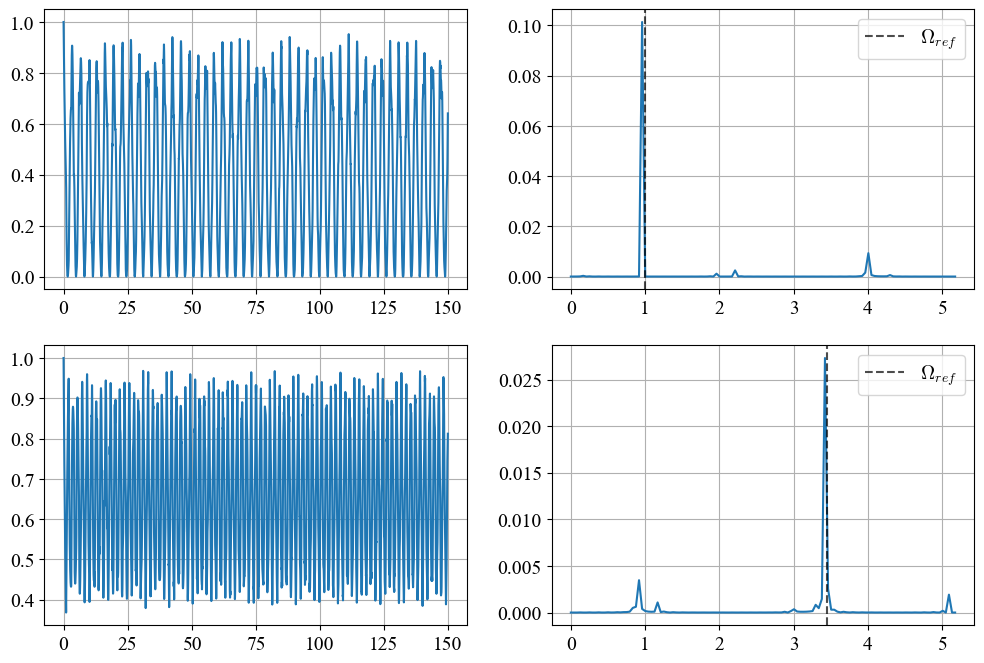

In [31]:
fig,axs = plt.subplots(2,2,figsize = (12,8))

axs[0,0].plot(t1,np.abs(e1))
axs[0,0].grid()

axs[0,1].plot(w1,np.abs(u1))
axs[0,1].axvline(np.sqrt(gamma/tau),linestyle='--',color='k',alpha = 0.7,label=r"$\Omega_{ref}$" )
axs[0,1].grid()
axs[0,1].legend()

axs[1,0].plot(t2,np.abs(e2))
axs[1,0].grid()

axs[1,1].plot(w2,np.abs(u2))
axs[1,1].axvline(np.sqrt(np.pi**2+2*gamma*tau)/tau,linestyle='--',color='k',alpha = 0.7,label=r"$\Omega_{ref}$" )
axs[1,1].grid()
axs[1,1].legend()

plt.show()


# 2. Driven case 

In [82]:
gamma = 1.2
tau = 1
phi = 2*np.pi 
frac = 1/5
t_max = 150*tau
dt = tau/75
w_ref = np.sqrt(gamma/tau)

In [83]:
t1,e1,I1,wa1,wi1,ua1,ui1 = exp001(gamma,tau,phi,frac,t_max,dt)
t2,e2,I2,wa2,wi2,ua2,ui2 = exp001(gamma,tau,phi/2,frac,t_max,dt)

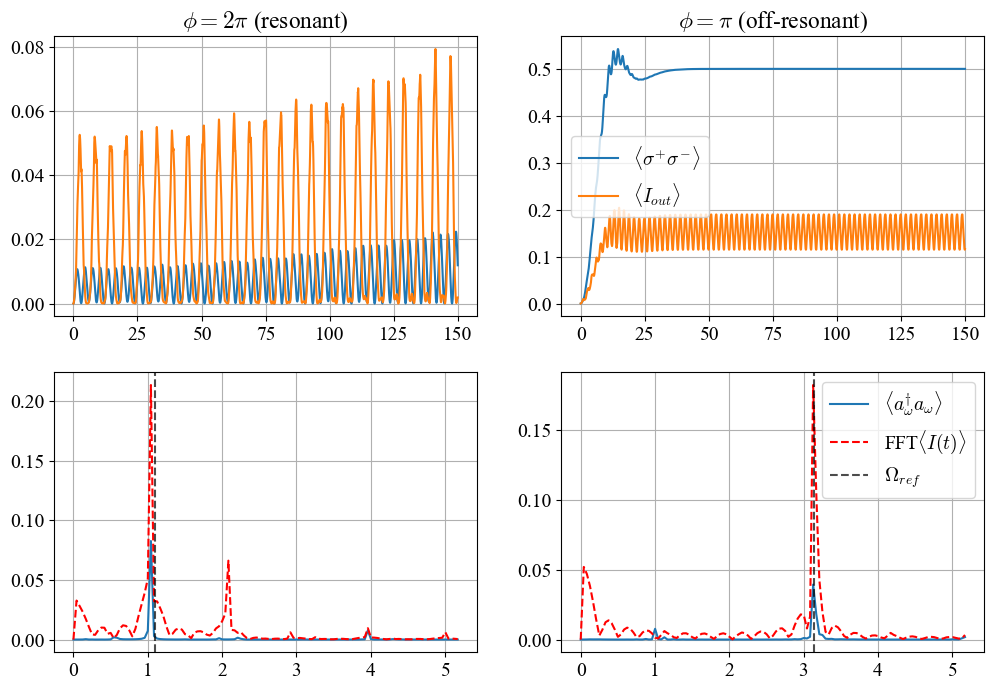

In [84]:
fig,axs = plt.subplots(2,2,figsize = (12,8))

axs[0,0].plot(t1,np.abs(e1))
axs[0,0].plot(t1,np.abs(I1),label=r"$\langle I_{out}\rangle $")
axs[0,0].grid()
axs[0,0].set_title(r"$\phi = 2\pi $ (resonant)")

axs[1,0].plot(wa1,np.abs(ua1),label=r"$\langle a_{\omega}^{\dag}a_{\omega} \rangle $")
axs[1,0].plot(wi1,np.abs(ui1),'r--',label=r"FFT $\langle I(t) \rangle$")
axs[1,0].axvline(np.sqrt(gamma/tau),linestyle='--',color='k',alpha = 0.7,label=r"$\Omega_{ref}$" )
axs[1,0].grid()


axs[0,1].plot(t2,np.abs(e2),label=r"$\langle \sigma^{+}\sigma^{-}\rangle $")
axs[0,1].plot(t2,np.abs(I2),label=r"$\langle I_{out}\rangle $")
axs[0,1].set_title(r"$\phi = \pi $ (off-resonant)")
axs[0,1].legend()
axs[0,1].grid()

axs[1,1].plot(wa1,np.abs(ua2),label=r"$\langle a_{\omega}^{\dag}a_{\omega} \rangle $")
axs[1,1].plot(wi1,np.abs(ui2),'r--',label=r"FFT$\langle I(t) \rangle$")
axs[1,1].axvline(np.pi/tau,linestyle='--',color='k',alpha = 0.7,label=r"$\Omega_{ref}$" )
axs[1,1].grid()
axs[1,1].legend()

plt.show()

Interestingly,

with $\phi = 2\pi $ , it seems like $g \to \frac{1}{\tau} $ 

with $\phi = \pi $ it seems like  $\Delta = \frac{\sqrt{\pi^{2}+2\gamma \tau}}{\tau} \longrightarrow \frac{\pi}{\tau}$

# 3.Inspection of the periodicity of the current 

The spectral density is 

$$ S(\omega) = 2 *Re \left[ \int_{0}^{\infty} d\tau \langle a^{\dag}_{out}(t+\tau)a_{out}(t)\rangle e^{i\omega \tau} d\tau \right] $$

In [5]:
def resample_uniform_tau(a_out, t, rho0, n_tau=512):
    """
    Correlation C(τ) with uniform spacing in tau.
    """
    t = np.asarray(t)
    a_ops = a_out.reshape((len(t), 2, 2))
    a0 = a_ops[0]
	# correlation 
    C_raw = np.array([np.trace(rho0 @ (a.conj().T @ a0)) for a in a_ops])
    tau_raw = t - t[0]
    
	# interpolation, same spacing benefits the Fourier transform 
    tau_min, tau_max = np.min(tau_raw), np.max(tau_raw)
    tau_uniform = np.linspace(tau_min, tau_max, n_tau)
    f_re = interp1d(tau_raw, C_raw.real, kind='cubic', fill_value="extrapolate")
    f_im = interp1d(tau_raw, C_raw.imag, kind='cubic', fill_value="extrapolate")
    C_uniform = f_re(tau_uniform) + 1j * f_im(tau_uniform)

    return tau_uniform, C_uniform

def S_w(a,t,initial,ntau): 
    ''' returns the spectral power deteceted by a photodetector'''
    tau,C = resample_uniform_tau(a,t,initial,ntau)
    w,u = fast_f_t(tau,C,500)
    return w,u

In [8]:
gamma = 1
phi =2*np.pi 
tau = 0.5
t_max = 100*tau
dt = tau/50 

initial = [1,0]
rho0 = np.outer(np.asarray([1,0]),np.asarray([1,0]))

In [ ]:
model=new_cav_model(gamma,phi,tau,0)
model.evolve(t_max,dt)
t,e = model.excited_state([1,0])
a_out = model.a_out_array

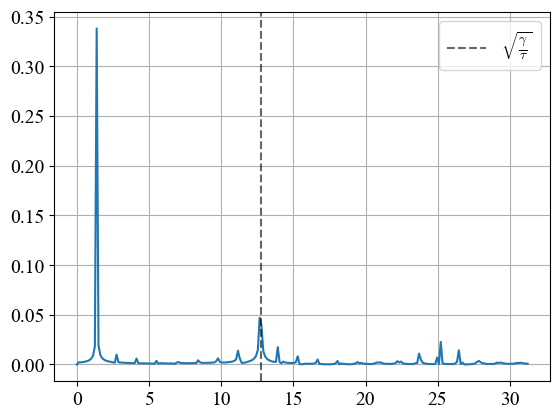

In [19]:
w,u = S_w(a_out,t,rho0,512)
plt.plot(w,u)
plt.axvline(9*np.sqrt(gamma/tau),color='k',linestyle='--',alpha=0.6,label=r'$\sqrt{\frac{\gamma}{\tau}}$')
plt.grid()
plt.legend()
plt.show()